In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

### Data cleaning and EDA

In [2]:
df_train = pd.read_csv('/Users/jsong/Documents/durg-recommendation/drugsCom_raw/drugsComTrain_raw.tsv',sep=None)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null float64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [4]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
del df_train['Unnamed: 0']
del df_train['date']

In [6]:
print("number of drugs:", len(df_train['drugName'].unique()))
print("number of conditions:", len(df_train['condition'].unique()))

number of drugs: 3436
number of conditions: 885


In [7]:
drug_per_condition = df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition

condition
Not Listed / Othe                 214
Pain                              200
Birth Control                     172
High Blood Pressure               140
Acne                              117
                                 ... 
Hypomagnesemia                      1
Hypopituitarism                     1
Hypotension                         1
Infectious Diarrhea                 1
Hypokalemic Periodic Paralysis      1
Name: drugName, Length: 884, dtype: int64

In [8]:
drug_per_condition[:30]

condition
Not Listed / Othe                             214
Pain                                          200
Birth Control                                 172
High Blood Pressure                           140
Acne                                          117
Depression                                    105
Rheumatoid Arthritis                           98
Diabetes, Type 2                               89
Allergic Rhinitis                              88
Bipolar Disorde                                80
Osteoarthritis                                 80
Insomnia                                       78
Anxiety                                        78
Abnormal Uterine Bleeding                      74
Migraine                                       59
Psoriasis                                      58
Endometriosis                                  57
3</span> users found this comment helpful.     57
ADHD                                           55
Asthma, Maintenance                     

In [9]:
#replace wrong name in condition column with NaN
df_train.loc[df_train['condition'].str.contains('</span>',case=False, na=False), 'condition'] = 'NAN'
df_train['condition'].replace('NAN', np.NaN, inplace=True)
df_train['condition'].replace('Not Listed / Othe', np.NaN, inplace=True)

In [10]:
#create a dictionary with drugname:condition to fill NaN
dictionary=df_train.set_index('drugName')['condition'].to_dict()
len(dictionary)

3436

In [11]:
#fill NaN value with correct condition names using created dictionary
df_train.condition.fillna(df_train.drugName.map(dictionary), inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 5 columns):
drugName       161297 non-null object
condition      161197 non-null object
review         161297 non-null object
rating         161297 non-null float64
usefulCount    161297 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.2+ MB


In [12]:
#drop rows with still missing values in condition (100 rows = 0.0006% of total data)
df_train.dropna(inplace=True)

In [13]:
drug_per_condition = df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drug_per_condition

condition
Pain                                            200
Birth Control                                   172
High Blood Pressure                             140
Acne                                            117
Depression                                      105
                                               ... 
Legionella Pneumonia                              1
Leukocytoclastic Vasculitis                       1
Lewy Body Dementia                                1
Ventricular Arrhythmia                            1
Postoperative Increased Intraocular Pressure      1
Name: drugName, Length: 810, dtype: int64

In [14]:
drug_per_condition[:30]

condition
Pain                         200
Birth Control                172
High Blood Pressure          140
Acne                         117
Depression                   105
Rheumatoid Arthritis          98
Diabetes, Type 2              89
Allergic Rhinitis             88
Bipolar Disorde               80
Osteoarthritis                80
Anxiety                       78
Insomnia                      78
Abnormal Uterine Bleeding     74
Migraine                      59
Psoriasis                     58
Endometriosis                 57
ADHD                          55
Asthma, Maintenance           54
Chronic Pain                  53
Migraine Prevention           50
Irritable Bowel Syndrome      49
Major Depressive Disorde      49
Urinary Tract Infection       47
ibromyalgia                   45
Postmenopausal Symptoms       44
Bronchitis                    44
GERD                          43
HIV Infection                 43
Bacterial Infection           43
Sinusitis                     42


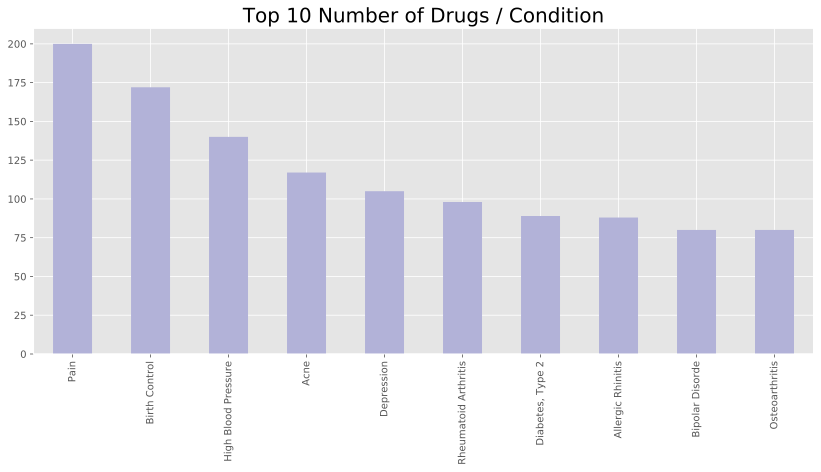

In [15]:
drug_per_condition[:10].plot(kind="bar", figsize = (14,6), fontsize = 10, color="#B2B2D8")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 10 Number of Drugs / Condition", fontsize = 20)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/top10_condition.svg')

In [16]:
#selecte conditions with less than 11 drug
condition_1=drug_per_condition[drug_per_condition<=10].keys()
condition_1

Index(['Social Anxiety Disorde', 'Constipation, Acute',
       'Postpartum Depression', 'Benign Essential Trem',
       'Primary Immunodeficiency Syndrome', 'Hypertriglyceridemia', 'Uveitis',
       'Malaria', 'Autism', 'Juvenile Rheumatoid Arthritis',
       ...
       'Scleroderma', 'Klinefelter Syndrome', 'Cogan's Syndrome',
       'Coccidioidomycosis', 'Cluster-Tic Syndrome', 'Legionella Pneumonia',
       'Leukocytoclastic Vasculitis', 'Lewy Body Dementia',
       'Ventricular Arrhythmia',
       'Postoperative Increased Intraocular Pressure'],
      dtype='object', name='condition', length=625)

In [17]:
#delete condition with only 1 drug
df_train1=df_train[~df_train['condition'].isin(condition_1)]
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148387 entries, 1 to 161296
Data columns (total 5 columns):
drugName       148387 non-null object
condition      148387 non-null object
review         148387 non-null object
rating         148387 non-null float64
usefulCount    148387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.8+ MB


In [18]:
import re # Regular expression library
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/jsong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jsong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jsong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
import spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
#remove words needs for sentiment analysis from stopwords
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

In [21]:
#add more words to stopwords
a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound', 'lb', 'month', 'day','night']
for j in a:
    stop.add(j)

In [22]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric=lambda x: re.sub('[^a-zA-Z]', ' ', x)
punc_lower=lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
split=lambda x: x.split()

df_train1['review'] = df_train1.review.map(alphanumeric).map(punc_lower).map(split)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
df_train1

,drugName,condition,review,rating,usefulCount
1,Guanfacine,ADHD,"[my, son, is, halfway, through, his, fourth, w...",8.0,192
2,Lybrel,Birth Control,"[i, used, to, take, another, oral, contracepti...",5.0,17
3,Ortho Evra,Birth Control,"[this, is, my, first, time, using, any, form, ...",8.0,10
5,Cialis,Benign Prostatic Hyperplasia,"[nd, day, on, mg, started, to, work, with, roc...",2.0,43
6,Levonorgestrel,Emergency Contraception,"[he, pulled, out, but, he, cummed, a, bit, in,...",1.0,5
...,...,...,...,...,...
161291,Junel 1.5 / 30,Birth Control,"[this, would, be, my, second, month, on, junel...",6.0,0
161293,Metoclopramide,Nausea/Vomiting,"[i, was, given, this, in, iv, before, surgey, ...",1.0,34
161294,Orencia,Rheumatoid Arthritis,"[limited, improvement, after, months, develope...",2.0,35
161295,Thyroid desiccated,Underactive Thyroid,"[i, ve, been, on, thyroid, medication, years, ...",10.0,79


In [24]:
#remove stopwords
df_train1['review_clean']=df_train1['review'].apply(lambda x: [item for item in x if item not in stop])

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
#stemming
df_train1['review_lemm']=df_train1['review_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
del df_train1['review']
del df_train1['review_clean']

In [27]:
df_train1['review']=df_train1['review_lemm'].apply(lambda x:' '.join(x))

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
del df_train1['review_lemm']
df_train1

,drugName,condition,rating,usefulCount,review
1,Guanfacine,ADHD,8.0,192,son halfway fourth intuniv became concerned be...
2,Lybrel,Birth Control,5.0,17,used take another contraceptive pill cycle hap...
3,Ortho Evra,Birth Control,8.0,10,first time using form birth control glad went ...
5,Cialis,Benign Prostatic Hyperplasia,2.0,43,nd started work rock hard erection however exp...
6,Levonorgestrel,Emergency Contraception,1.0,5,pulled cummed bit took plan b hour later took ...
...,...,...,...,...,...
161291,Junel 1.5 / 30,Birth Control,6.0,0,would second junel birth control year changed ...
161293,Metoclopramide,Nausea/Vomiting,1.0,34,given surgey immediately became anxious could ...
161294,Orencia,Rheumatoid Arthritis,2.0,35,limited improvement month developed bad rash m...
161295,Thyroid desiccated,Underactive Thyroid,10.0,79,thyroid medication year spent first synthroid ...


In [29]:
export_csv = df_train1.to_csv(r'/Users/jsong/Documents/durg-recommendation/df_train.csv', index = None, header=True)

In [30]:
df_test = pd.read_csv('/Users/jsong/Documents/durg-recommendation/drugsCom_raw/drugsComTest_raw.tsv',sep=None)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     53766 non-null int64
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null float64
date           53766 non-null object
usefulCount    53766 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [32]:
del df_test['Unnamed: 0']
del df_test['date']

In [33]:
print("number of drugs:", len(df_test['drugName'].unique()))
print("number of conditions:", len(df_test['condition'].unique()))

number of drugs: 2637
number of conditions: 709


In [34]:
#delete condition with only 1 drug
df_test1=df_test[~df_test['condition'].isin(condition_1)]
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49470 entries, 0 to 53765
Data columns (total 5 columns):
drugName       49470 non-null object
condition      49175 non-null object
review         49470 non-null object
rating         49470 non-null float64
usefulCount    49470 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.3+ MB


In [35]:
df_test1.dropna(inplace=True)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphanumeric=lambda x: re.sub('[^a-zA-Z]', ' ', x)
punc_lower=lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
split=lambda x: x.split()

df_test1['review'] = df_test1.review.map(alphanumeric).map(punc_lower).map(split)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
#remove stopwords
df_test1['review_clean']=df_test1['review'].apply(lambda x: [item for item in x if item not in stop])

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
#Stemming
df_test1['review_lemm']=df_test1['review_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
del df_test1['review']
del df_test1['review_clean']

In [40]:
df_test1['review']=df_test1['review_lemm'].apply(lambda x:' '.join(x))

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
del df_test1['review_lemm']
df_test1

,drugName,condition,rating,usefulCount,review
0,Mirtazapine,Depression,10.0,22,tried antidepressant year citalopram fluoxetin...
1,Mesalamine,"Crohn's Disease, Maintenance",8.0,17,son crohn disease done well asacol no complain...
2,Bactrim,Urinary Tract Infection,9.0,3,quick reduction symptom
3,Contrave,Weight Loss,9.0,35,contrave combine drug used alcohol smoking opi...
4,Cyclafem 1 / 35,Birth Control,9.0,4,birth control one cycle reading review type si...
...,...,...,...,...,...
53760,Apri,Birth Control,9.0,18,started taking apri month ago breats got notic...
53762,Escitalopram,Anxiety,9.0,11,taking lexapro escitaploprgram since first lik...
53763,Levonorgestrel,Birth Control,8.0,7,married year old no kid taking pill hassle dec...
53764,Tapentadol,Pain,1.0,20,prescribed nucynta severe neck shoulder pain t...


In [42]:
export_csv = df_test1.to_csv(r'/Users/jsong/Documents/durg-recommendation/df_test.csv', index = None, header=True)